# Introduction to Elasticsearch

## Contents
* [Distributed Search Engine](#Distributed-Search-Engine)
* [Architecture](#Architecture)
* [Indices and Documents](#Indices-and-Documents)
* [Inverted index](#Inverted-index)
* [Relevance score](#Relevance-score)
* [Primary and replica shards](#Primary-and-replica-shards)
* [Mapping](#Mapping)
* [About OpenSearch](#About-OpenSearch)


## Distributed Search Engine
ElasticSearch is a distributed search engine based on **Apache Lucene** (originally written by Doug Cutting, do your remember him? He is also the creator of Apache Hadoop and the parquet format is based on the Trevni columnar storage format also created by him).

ElasticSearch uses a RESTful API (more on that later).

ElasticSearch is document-based (documents are represented as JSON objects).

## Architecture

![HA Architecture](http://bigdata.cesga.es/img/elasticsearch_architecture.png)

To create a fault-tolerant elasticsearch cluster we need a least three master-eligible nodes (or a higher odd-number). This way if one of them fails then the remaining two still form a majority and can hold a successful election. We will also need two nodes of each role, so if one fails the other can take control, and all indexes must be configured so they have at least one replica shard, so we will have two copies of each shard.

It is good practice to limit the number of master-eligible nodes in the cluster to three.

If we have more than three nodes, then we can dedicate different nodes to different services: we will use three as master nodes, but the others can be dedicated as data nodes, logstash nodes, kibana, etc.

```
Master nodes do not scale like other node types since the cluster always elects just one of them as the master of the cluster. If there are too many master-eligible nodes then master elections may take a longer time to complete. In larger clusters, we recommend you configure some of your nodes as dedicated master-eligible nodes and avoid sending any client requests to these dedicated nodes. Your cluster may become unstable if the master-eligible nodes are overwhelmed with unnecessary extra work that could be handled by one of the other nodes.

You may configure one of your master-eligible nodes to be a voting-only node so that it can never be elected as the master node. For instance, you may have two dedicated master nodes and a third node that is both a data node and a voting-only master-eligible node. This third voting-only node will act as a tiebreaker in master elections but will never become the master itself.
```


## Indices and Documents
The main concepts to understand in ElasticSearch are indices and documents.

A index is a collection of documents, it is similar to the concept of a table in a SQL database. It contains documents that follow a certain schema that is defined by the index mappings.

A document is each of the elements inside a index, it is similar to the concept of a table row in SQL.

A document is represented as JSON object and it can contain different fields with text, numeric values, lists, etc.

ElasticSearch uses a **dynamic schema**: it will infer it if you do not provide it.

We can aslo indicate **relationships** between the documents:
- Nested
- Parent/Child

## Inverted index
Behind the scenes a ElasticSearch index uses what is called an inverted index.

To see how it works imagine:
- Document 1: "The first document"
- Document 2: "The second document"

The inverted index could be something like:
- "the": 1, 2
- "first": 1
- "document": 1, 2
- "second": 2

## Relevance score
As we will see in ElasticSearch queries produce relevancy scores for each result (it is not just match or not match).

The relevance score is based in a ranking function using a metric like **Term Frequency–Inverse Document Frequency (TF-IDF)**:

- TF (Term Frequency): measures the relative frequency of the term in the document
- IDF (Inverse Document Frequency): measures how much information the term provides, i.e. if the term is common or rare across all documents.

There are different variants to represent TF and IDF, a simple one is the following:

```
TF*IDF = n/N * log(D/n)
```

- n: number of times that the term appears in the document
- N: total number of terms in the document
- D: total number of documents
- d: number of documents that contain the term

so that in this case:
```
TF = n/N
IDF = log(D/d)
```

This way TFIDF would give a measure the relevance of a term in a given document.

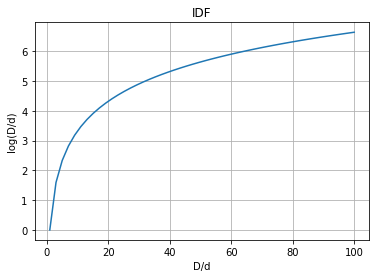

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1, 100)
y = np.log2(x)

plt.plot(x, y)
plt.title('IDF')
plt.xlabel('D/d')
plt.ylabel('log(D/d)')
plt.grid()
plt.show()

## Primary and replica shards

![Primary and replica shards](http://bigdata.cesga.es/img/elasticsearch_shards.png)

ElasticSearch is a way a distributed Lucene. To achieve this what ElasticSearch does is to introduce the idea of **shards** (similar to the idea of partitions in Spark). Every shard is a self-contained Lucene instance.

An Elasticsearch index is really just a logical grouping of one or more physical shards, where each shard is actually a self-contained index.

A index in ElasticSearch is distributed across different shards. To achieve this, each time that we add a new document to an index, elasticsearch computes its hash and based on the result it sends its to a particular hash (similar to what a partitioner does in spark).

Each shard can be on a different node of the cluster, and a node can have several shards.

There are two types of shards:
- **Primary shard**
- **Replica shard**: it contains a replica of the data in the primary shard, it can be promoted as the primary shard in the case that the primary shard is not available

**Each document in an index belongs to one primary shard.**

Requests are routed automatically to the appropriate shard:
- **Write** requests are routed to the primary shard and then they are replicated.
- **Read** requests are routed to any of the shards (primary or replica)

It is important to tune the number of shards since it determines the parallelism: 
```
Querying lots of small shards makes the processing per shard faster, but more queries means more overhead, so there are cases when querying a smaller number of larger shards might be faster. In short... it depends.
```

**The number of primary shards in an index can not be changed**, it is fixed at the time that an index is created, but **the number of replica shards can be changed at any time**, without interrupting indexing or query operations.

Elasticsearch automatically migrates shards to rebalance the cluster.

## Mapping
ElasticSearch uses a **dynamic schema**: it will infer it from the documents that are inserted in the index if you do not provide it in avdance.

In ElasticSearch defining the schema is referred as **mapping**: Mapping is the process of defining how a document and its fields are stored and indexed in ElasticSearch.

We can use **dynamic mapping** or **explicit mapping** to define how our data will be represented.

In general the recommendation for production use-cases is to use explicit mapping.

In ElasticSearch defining the schema is referred as **mapping**: Mapping is the process of defining how a document and its fields are stored and indexed in ElasticSearch.

We can use **dynamic mapping** or **explicit mapping** to define how our data will be represented.

In general the recommendation for production use-cases is to review the mappings and use explicit mappings where needed.

## Text Analyzers
In general ElasticSearch will pass the text of a given field through the configured **analyzers** and **tokenizers** before storing it.

The text analysis process consists of two parts: tokenization and normalization.
- Tokenization: splitting the text into individual words
- Normalization: individual tokens (words) are transformed and enriched: converting to lower case, removing stopwords, reducing the words to their root words (stemming), applying synonyms (synoymizing), etc.

This allows **full-text search**.

## About OpenSearch
Elastic changed its license from version 7.11.

```
OpenSearch is a community-driven, open source fork of Elasticsearch and Kibana following the licence change in early 2021. We're looking to sustain (and evolve!) a search and analytics suite for the multitude of businesses who are dependent on the rights granted by the original, Apache v2.0 License.
```

OpenSearch is a fully open source search and analytics suite. OpenSearch includes OpenSearch (**derived from Elasticsearch 7.10.2**) and OpenSearch Dashboards (**derived from Kibana 7.10.2**), and a range of features like built-in security, anomaly detection, alerting, observability experiences, and more.

## Exercises

Let's get our hands dirty and let's see how all this works:

- Lab 1:
  - [Installing OpenSearch, Kibana and Logstash (single-node)](exercises/installing_opensearch_kibana_and_logstash_single-node.md)
- Lab 2 (for the brave ones, once you did lab 1):
  - [Installing OpenSearch, Kibana and Logstash (cluster-mode)](exercices/installing_opensearch_kibana_and_logstash_cluster-mode.md)

## References
- [Scalability and resilience: clusters, nodes, and shards](https://www.elastic.co/guide/en/elasticsearch/reference/current/scalability.html)
- [Important Elasticsearch configuration](https://www.elastic.co/guide/en/elasticsearch/reference/current/important-settings.html#important-settings)
- [Set up a cluster for high availability](https://www.elastic.co/guide/en/elasticsearch/reference/current/high-availability.html)
- [Elasticsearch Text Analyzers – Tokenizers, Standard Analyzers, Stopwords and More](https://opster.com/guides/elasticsearch/data-architecture/elasticsearch-text-analyzers/#elasticsearch-text-analysis-tokenization-normalization)